# Variational Quantum Eigensolver (VQE) with Quantum Structure Diagrams (QSDs)

This notebook demonstrates a **QSD-enhanced VQE "diagnose → fix" workflow** on three progressively richer examples:

1. **Example 1 (H):** a 1‑qubit toy Hamiltonian to introduce VQE mechanics and QSD reading.
2. **Example 2 ($H_2$ simple):** a 1‑qubit reduced model with a nuclear-repulsion shift (closer to chemistry conventions).
3. **Example 3 ($H_2$ proper):** a 4‑qubit qubit‑Hamiltonian where **sector/subspace structure matters**, and where QSD diagnostics reveal **leakage** that can be fixed by choosing a structure‑respecting ansatz.

**Execution model:** we keep the same overall Runtime-style execution structure using a **FakeBackend** (so the notebook runs without IBM credentials).  
**QSD assumption:** the QSD package is available in your environment; the notebook uses it directly (no fallbacks).

---

## Environment

If you're running locally, ensure these are installed:

- `qiskit` (≥ 2.1)
- `qiskit_ibm_runtime`
- `qiskit-aer`
- `numpy`
- `matplotlib`
- `ipywidgets`
- `pylatexenc`
- `qsd` (your QSD plotting/metrics package)

```python
# Uncomment if needed:
# !pip install "qiskit>=2.1.0" "qiskit-ibm-runtime>=0.40.1" "qiskit-aer>=0.17.0" numpy matplotlib ipywidgets pylatexenc
```


## Paper notation used in this notebook (QSD conventions + metrics)

We follow the exact statevector/QSD specification used in the paper.

### Statevector bookkeeping

A normalized pure state in the computational basis is
$$
\lvert\psi\rangle=\sum_{i=0}^{N-1} c_i\lvert b_i\rangle,\qquad \sum_i |c_i|^2=1.
$$

A **QSD layout** is specified by:

- a **grouping** $G$ that assigns each basis label $b_i$ to a **row index** $r$,
- and within each row $r$, an ordering $\pi_r$ that places the row's basis states into **cells**.

This induces a partition of the computational basis into row-sets $\{\mathcal{B}_r\}$, where
$$
\mathcal{B}_r=\{\,b_i\;:\; G(b_i)=r\,\},\qquad N_r=|\mathcal{B}_r|.
$$

In all examples below we use **excitation/Hamming-weight grouping** on qubits:
$$
G(b)=\mathrm{wt}(b)\in\{0,1,\dots,n\},
$$
so each row corresponds to a fixed excitation number (useful for diagnosing particle-number / excitation-sector structure).

### QSD cell encoding (visual)

- cell brightness encodes $|c_i|$,
- cell hue encodes $\arg(c_i)$,
under the fixed layout $(G,\{\pi_r\})$.

### Layout-aligned diagnostics (shown in plots and in the widget)

Define the row projector $\Pi_r$ onto the span of $\mathcal{B}_r$. The paper's row-aligned metrics:

**Row probability weight**
$$
P_{\mathrm{row}}(r)=\langle\psi|\Pi_r|\psi\rangle=\sum_{b_i\in\mathcal{B}_r}|c_i|^2.
$$

Define conditional probabilities within row $r$:
$$
\tilde p_{r,\ell}=\frac{|c_{r,\ell}|^2}{P_{\mathrm{row}}(r)}\quad (\text{for }P_{\mathrm{row}}(r)>0).
$$

**Within-row amplitude entropy**
$$
S_{\mathrm{amp}}(r)=-\sum_{\ell=1}^{N_r}\tilde p_{r,\ell}\log_2 \tilde p_{r,\ell},
\qquad
N_{\mathrm{eff}}(r)=2^{S_{\mathrm{amp}}(r)}.
$$

**Row colinearity (phase alignment proxy)**
$$
C_{\mathrm{row}}(r)=\frac{\left|\sum_{\ell=1}^{N_r} c_{r,\ell}\right|}{\sum_{\ell=1}^{N_r}|c_{r,\ell}|},
$$
(with the convention $C_{\mathrm{row}}(r)=0$ if the denominator is 0).

**Row delocalization across sectors**
$$
D_{\mathrm{row}}=\frac{1}{\sum_r P_{\mathrm{row}}(r)^2}.
$$

In Example 3 we will also track **leakage from a target sector** $r_\star$:
$$
L_{\mathrm{row}}(r_\star)=1-P_{\mathrm{row}}(r_\star).
$$

> Intuition: if the physics says “the state should stay in a sector”, then $L_{\mathrm{row}}$ quantifies sector leakage and QSDs show **where** the leaked weight goes.


In [1]:
import numpy as np

# Plotting / widgets
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output, Image
import io
import json
from pathlib import Path
from collections import OrderedDict
import imageio.v2 as imageio

# Qiskit core
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp

# Runtime-style primitives on a fake backend
from qiskit_ibm_runtime.fake_provider import FakeFez
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Batch

# Transpilation
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Classical optimizer
from scipy.optimize import minimize

# QSD plotting
from qsd import compute_qsd_metrics, plot_qsd

# For Example 3 ansatz (new-style APIs; the class versions are deprecated)
from qiskit.circuit.library.n_local import n_local
from qiskit.circuit.library import excitation_preserving

np.random.seed(7)


In [2]:
# --- FakeFez as the backend ---
backend = FakeFez()

# We'll reuse a single preset pass manager for ISA conversion
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

print("Fake backend:", backend.configuration().backend_name)


Fake backend: fake_fez


## Execution model

Even though we run on a *fake* backend, we follow the same conceptual pipeline used for real hardware:

1. **Transpile to backend ISA** (instruction set architecture) using a preset pass manager.
2. **Apply the same layout** to the Hamiltonian so the observable matches the transpiled qubit mapping.
3. Use the **Estimator primitive** to evaluate the expectation value $(E(\theta)=\langle\psi(\theta)\vert H \vert\psi(\theta)\rangle)$.
4. Use a classical optimizer (COBYLA here) to update $(\theta)$.

In parallel, we compute the **exact statevector** of the *logical* ansatz circuit at each iteration solely for **QSD diagnostics**.


In [3]:
# ----------------------------
# QSD + VQE helper utilities
# ----------------------------

def _statevector_from_params(circuit: QuantumCircuit, params) -> Statevector:
    '''Return the exact statevector of the parameter-bound circuit (no measurements).'''
    bound = circuit.assign_parameters(params, inplace=False)
    return Statevector.from_instruction(bound)


def transpile_and_layout(ansatz: QuantumCircuit, hamiltonian: SparsePauliOp):
    '''Transpile ansatz to ISA circuit for the fake backend and apply the same layout to the Hamiltonian.'''
    ansatz_isa = pm.run(ansatz)
    ham_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)
    return ansatz_isa, ham_isa


def vqe_cost_func(params, ansatz_isa, hamiltonian_isa, estimator, history: dict, sv_circuit: QuantumCircuit):
    '''
    Runtime-style cost function: E(θ) = <ψ(θ)|H|ψ(θ)> estimated by EstimatorV2.

    Also records:
      - energy history,
      - parameter history,
      - exact statevector history (for QSD diagnostics only).
    '''
    pub = (ansatz_isa, [hamiltonian_isa], [params])
    energy = estimator.run([pub]).result()[0].data.evs[0]

    history["iters"] += 1
    history["cost_history"].append(float(energy))
    history["param_history"].append(np.array(params, dtype=float))

    # Exact statevector (diagnostics only; not used for energy evaluation)
    history["statevector_history"].append(_statevector_from_params(sv_circuit, params))
    return energy


def run_vqe_with_history(
    ansatz: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    x0,
    maxiter: int = 25,
    tol: float = 1e-2,
    shots: int = 10_000,
    method: str = "cobyla",
):
    '''
    Keeps the same Batch+EstimatorV2 structure you used, but returns a rich history
    (energies, params, statevectors) for QSD diagnostics.
    '''
    ansatz_isa, ham_isa = transpile_and_layout(ansatz, hamiltonian)

    batch = Batch(backend=backend)
    estimator = Estimator(mode=batch)
    estimator.options.default_shots = shots

    history = {
        "iters": 0,
        "cost_history": [],
        "param_history": [],
        "statevector_history": [],
        "ansatz": ansatz,
        "ansatz_isa": ansatz_isa,
        "hamiltonian": hamiltonian,
        "hamiltonian_isa": ham_isa,
    }

    res = minimize(
        vqe_cost_func,
        x0,
        args=(ansatz_isa, ham_isa, estimator, history, ansatz),
        method=method,
        options={"maxiter": maxiter, "tol": tol},
    )

    batch.close()
    return res, history

def exact_ground_state_energy(hamiltonian, *, assume_hermitian=True) -> float:
    """
    Return exact ground-state energy of a qubit Hamiltonian.

    Works for SparsePauliOp and anything that can provide a dense matrix.
    For your notebook sizes (1–4 qubits), dense is perfectly fine.
    """
    # Qiskit SparsePauliOp / Operator typically support to_matrix()
    if hasattr(hamiltonian, "to_matrix"):
        H = np.asarray(hamiltonian.to_matrix(), dtype=complex)
    else:
        H = np.asarray(hamiltonian, dtype=complex)

    if assume_hermitian:
        # Hermitian eigensolver (real eigenvalues)
        evals = np.linalg.eigvalsh(H)
    else:
        evals = np.linalg.eigvals(H)

    return float(np.min(evals.real))


In [4]:
# ---- QSD per-iteration widget (NOT just init/mid/final) ----

def qsd_iteration_widget(
    history: dict,
    *,
    grouping: str = "hamming",
    ordering: str = "lex",
    phase_gauge=("index", 0),
    annotate_threshold: float = 0.0,
    title_prefix: str = "",
    show_metrics: bool = True,
    save_artifacts: bool = True,
    out_dir: str = "qsd_artifacts",
    run_tag: str | None = None,
    gif_fps: int = 2,
    gif_every: int = 1,              # 1 = every iter in GIF
    save_frames: bool = False,       # default OFF (big win). turn on if you truly want per-iter PNGs.
    frames_every: int = 1,           # if save_frames True
    write_metrics_json: bool = True,
    include_statevector_in_json: bool = False,  # usually False
    json_include_haar: bool = False,            # usually False (large)
    json_include_sep_test: bool = True,
    png_cache_max: int = 20,         # LRU cache size for interactive scrubbing
):
    """
    Interactive QSD scrubber + portable artifacts with minimal re-rendering:
      - Metrics computed once for all iterations (compute_qsd_metrics)
      - GIF written by streaming frames (no need to save per-iter PNGs)
      - Start/mid/end snapshots saved as PNG
      - Optional: save per-iter PNG frames (disabled by default)
      - One JSON file with metrics for all iterations

    Requires: plot_qsd, compute_qsd_metrics, ipywidgets, clear_output, widgets.
    """
    svs = history.get("statevector_history", [])
    costs = history.get("cost_history", [])
    n_steps = min(len(svs), len(costs))
    if n_steps == 0:
        print("No statevectors/costs recorded (history is empty or mismatched).")
        return

    if run_tag is None:
        run_tag = title_prefix.strip().replace(" ", "_").replace(":", "")
        run_tag = run_tag if run_tag else "run"

    out = Path(out_dir)
    snaps_dir = out / "snapshots" / run_tag
    frames_dir = out / "frames" / run_tag
    out.mkdir(parents=True, exist_ok=True)
    if save_artifacts:
        snaps_dir.mkdir(parents=True, exist_ok=True)
        if save_frames:
            frames_dir.mkdir(parents=True, exist_ok=True)

    def _vec(sv):
        return sv.data if hasattr(sv, "data") else np.asarray(sv, dtype=complex)

    # -------------------------
    # 1) Compute metrics once
    # -------------------------
    metrics_all = []
    rowkeys_union = set()

    for i in range(n_steps):
        psi = _vec(svs[i])
        m = compute_qsd_metrics(psi, grouping=grouping, ordering=ordering)
        metrics_all.append(m)
        for rk in m.get("row_keys", []):
            rowkeys_union.add(rk)

    # -------------------------
    # 2) PNG renderer (bytes)
    # -------------------------
    def _render_png_bytes(i: int, *, show_metrics_local: bool) -> bytes:
        psi = _vec(svs[i])
        E = float(costs[i])

        buf = io.BytesIO()
        fig = None
        try:
            fig = plot_qsd(
                psi,
                grouping=grouping,
                ordering=ordering,
                phase_gauge=phase_gauge,
                annotate_threshold=annotate_threshold,
                show_metrics=show_metrics_local,
                caption=f"{title_prefix} iter={i}  E={E:.6f}",
                style="paper",
                theme="light",
                show=False,
                return_fig=True,
            )
            fig.savefig(buf, format="png", dpi=160, bbox_inches="tight")
        finally:
            if fig is not None:
                plt.close(fig)

        buf.seek(0)
        return buf.getvalue()

    # -------------------------
    # 3) Save JSON (metrics all iters)
    # -------------------------
    if save_artifacts and write_metrics_json:
        payload = {
            "meta": {
                "grouping": grouping,
                "ordering": ordering,
                "phase_gauge": list(phase_gauge) if isinstance(phase_gauge, tuple) else phase_gauge,
                "annotate_threshold": float(annotate_threshold),
                "n_steps": int(n_steps),
                "run_tag": run_tag,
            },
            "energy_trace": [float(costs[i]) for i in range(n_steps)],
            "rows_union": sorted(list(rowkeys_union)),
            "metrics_per_iter": [],
        }

        for i, m in enumerate(metrics_all):
            rec = {
                "iter": int(i),
                "E": float(costs[i]),
                "row_delocalization": float(m["row_delocalization"]),
                "row_keys": list(m.get("row_keys", [])),
                "row_probabilities": m.get("row_probabilities", {}),
                "row_amplitude_entropy": m.get("row_amplitude_entropy", {}),
                "row_effective_support": m.get("row_effective_support", {}),
                "row_phase_alignment": m.get("row_phase_alignment", {}),
                "bipartite_entanglement_linear": m.get("bipartite_entanglement_linear", None),
                "meta_resolved": m.get("meta", {}),
            }
            if json_include_sep_test:
                rec["aligned_separability_test"] = m.get("aligned_separability_test", None)
            if json_include_haar:
                rec["haar_baselines"] = m.get("haar_baselines", None)
            if include_statevector_in_json:
                psi = _vec(svs[i])
                rec["statevector_re"] = [float(x.real) for x in psi]
                rec["statevector_im"] = [float(x.imag) for x in psi]

            payload["metrics_per_iter"].append(rec)

        json_path = out / f"{run_tag}_metrics.json"
        json_path.write_text(json.dumps(payload, indent=2), encoding="utf-8")
        print(f"[saved] metrics JSON: {json_path}")

    # -------------------------
    # 4) Save snapshots (start/mid/end)
    # -------------------------
    if save_artifacts:
        snap_indices = [0, (n_steps - 1) // 2, n_steps - 1]
        for i in snap_indices:
            png = _render_png_bytes(i, show_metrics_local=show_metrics)
            (snaps_dir / f"{run_tag}_iter{i:03d}.png").write_bytes(png)
        print(f"[saved] snapshots: {snaps_dir}")

    # -------------------------
    # 5) Stream-write GIF (no per-frame PNGs required)
    # -------------------------
    if save_artifacts:
        gif_path = out / f"{run_tag}_evolution.gif"
        step = max(1, int(gif_every))
        with imageio.get_writer(gif_path, mode="I", fps=int(gif_fps)) as writer:
            for i in range(0, n_steps, step):
                # For GIF, usually cleaner/faster without title-band metrics:
                png = _render_png_bytes(i, show_metrics_local=True)
                img = imageio.imread(io.BytesIO(png))
                writer.append_data(img)
        print(f"[saved] GIF: {gif_path}")

    # Optional: also dump frames to disk (off by default)
    if save_artifacts and save_frames:
        step = max(1, int(frames_every))
        for i in range(0, n_steps, step):
            png = _render_png_bytes(i, show_metrics_local=True)
            (frames_dir / f"{run_tag}_frame{i:03d}.png").write_bytes(png)
        print(f"[saved] frames: {frames_dir}")

    # -------------------------
    # 6) Interactive widget (LRU PNG cache)
    # -------------------------
    png_cache = OrderedDict()  # i -> bytes

    def _get_png_cached(i: int) -> bytes:
        if i in png_cache:
            png_cache.move_to_end(i)
            return png_cache[i]
        png = _render_png_bytes(i, show_metrics_local=show_metrics)
        png_cache[i] = png
        if len(png_cache) > int(png_cache_max):
            png_cache.popitem(last=False)
        return png

    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=n_steps - 1,
        step=1,
        description="iter",
        continuous_update=False,
        readout=True,
        style={"description_width": "40px"},
        layout=widgets.Layout(width="500px"),
    )
    out_plot = widgets.Output()
    out_text = widgets.Output()

    def _render(i: int):
        png = _get_png_cached(i)

        with out_plot:
            clear_output(wait=True)
            display(Image(data=png, format="png"))

        with out_text:
            clear_output(wait=True)
            m = metrics_all[i]
            meta = m.get("meta", {})
            dims = meta.get("dims", [])
            n = len(dims) if dims else int(np.log2(len(_vec(svs[i]))))

            print(f"n={n} qubits | G={meta.get('grouping_resolved','?')} | π={meta.get('ordering_resolved','?')}")
            print(f"D_row = {m['row_delocalization']:.6f}")
            print(f"E_lin(A:B) = {m.get('bipartite_entanglement_linear', None)}")

            st = m.get("aligned_separability_test", None)
            if isinstance(st, dict):
                if "rank_one" in st:
                    print(f"Aligned separability test (rank-one): {st['rank_one']}")
                elif "sigma_ratio" in st:
                    print(f"Aligned separability test (sigma ratio): {st['sigma_ratio']}")

            print("\nr : P_row(r)   S_amp(r)   N_eff(r)   C_row(r)")
            rows = m.get("row_keys", [])[:8]
            for r in rows:
                P = m["row_probabilities"][r]
                S = m["row_amplitude_entropy"][r]
                N_eff = m["row_effective_support"][r]
                C = m["row_phase_alignment"][r]
                print(f"{r:>3} : {P:.6f}   {S:.4f}   {N_eff:.3f}   {C:.4f}")

    def _on_change(change):
        if change["name"] == "value":
            _render(change["new"])

    slider.observe(_on_change)
    _render(0)
    display(widgets.VBox([slider, out_plot, out_text]))


# Example 1 — Hydrogen atom toy model (1 qubit)

This first example is intentionally minimal so that we can focus on the **mechanics of VQE** and the **reading of QSDs**.

## 1.1 Qubit Hamiltonian for H (1 qubit)

A 1‑qubit Hamiltonian can always be written as a linear combination of Pauli operators:
$$
\hat H = \alpha I + \beta X + \gamma Y + \delta Z.
$$

For this pedagogical H example (from the IBM learning module), we use:

$$
\hat H_H = -1.05237\, I + 0.39794\, Z + 0.18093\, X .
$$

**Interpretation:** this is already a *qubit Hamiltonian* (no chemistry mapping work required here), so we can focus on VQE.

## 1.2 VQE loop (three ingredients)

1. **Observable:** the Hamiltonian $( \hat H )$ whose expectation we can estimate on quantum hardware.
2. **Ansatz:** a parameterized circuit $(U(\theta))$ that prepares $(\lvert\psi(\theta)\rangle = U(\theta)\lvert 0\rangle)$.
3. **Optimizer:** a classical routine that updates $(\theta)$ to minimize $(E(\theta)=\langle\psi(\theta)|\hat H|\psi(\theta)\rangle)$.

We will compare three 1‑qubit ansatz of increasing expressivity and use QSDs to inspect what the optimizer is *actually doing* at each iteration.


In [5]:
# --- Hamiltonian for H (1 qubit) ---
h_hamiltonian = SparsePauliOp.from_list(
    [
        ("I", -1.052373245772859),
        ("Z",  0.39793742484318045),
        ("X",  0.18093119978423156),
    ]
)

print("H Hamiltonian:", h_hamiltonian)
E_ref = exact_ground_state_energy(h_hamiltonian)
print("Exact ground state energy =", E_ref, "Ha")


H Hamiltonian: SparsePauliOp(['I', 'Z', 'X'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j,  0.1809312 +0.j])
Exact ground state energy = -1.4895120030870364 Ha


A1_Rx num_params = 1


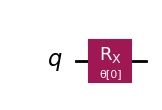

A2_RxRz num_params = 2


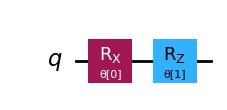

A3_RxRzRx num_params = 3


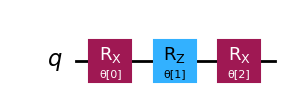

In [6]:
from qiskit.circuit import ParameterVector

# Three 1-qubit ansatz (increasing expressivity)
θ1 = ParameterVector("θ", 1)
θ2 = ParameterVector("θ", 2)
θ3 = ParameterVector("θ", 3)

ansatz_1 = QuantumCircuit(1, name="A1_Rx")
ansatz_1.rx(θ1[0], 0)

ansatz_2 = QuantumCircuit(1, name="A2_RxRz")
ansatz_2.rx(θ2[0], 0)
ansatz_2.rz(θ2[1], 0)

ansatz_3 = QuantumCircuit(1, name="A3_RxRzRx")
ansatz_3.rx(θ3[0], 0)
ansatz_3.rz(θ3[1], 0)
ansatz_3.rx(θ3[2], 0)

ansatz_list = [ansatz_1, ansatz_2, ansatz_3]
for a in ansatz_list:
    print(a.name, "num_params =", a.num_parameters)
    display(a.draw("mpl"))



A1_Rx:
  final energy = -1.4425036040473527
  nit = 22
  nit  = 22
  iters recorded = 22
  nfev = 22


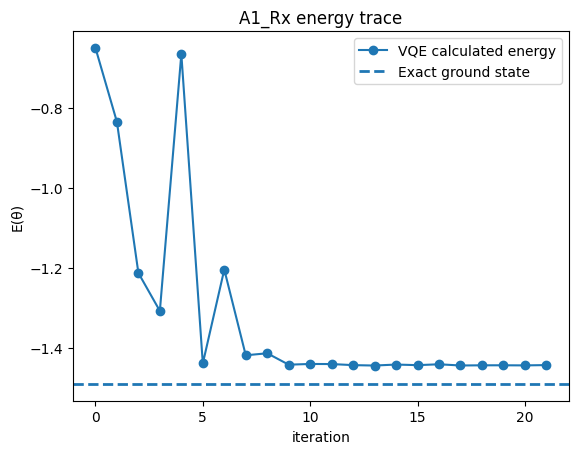

[saved] metrics JSON: figures/artifacts/ex_1/A1_Rx_H_metrics.json
[saved] snapshots: figures/artifacts/ex_1/snapshots/A1_Rx_H
[saved] GIF: figures/artifacts/ex_1/A1_Rx_H_evolution.gif



A2_RxRz:
  final energy = -1.4800860309882387
  nit = 25
  nit  = 25
  iters recorded = 25
  nfev = 25


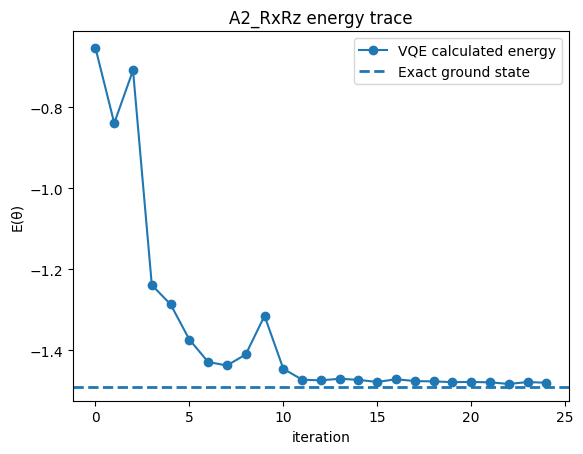

[saved] metrics JSON: figures/artifacts/ex_1/A2_RxRz_H_metrics.json
[saved] snapshots: figures/artifacts/ex_1/snapshots/A2_RxRz_H
[saved] GIF: figures/artifacts/ex_1/A2_RxRz_H_evolution.gif



A3_RxRzRx:
  final energy = -1.4824339174021546
  nit = 25
  nit  = 25
  iters recorded = 25
  nfev = 25


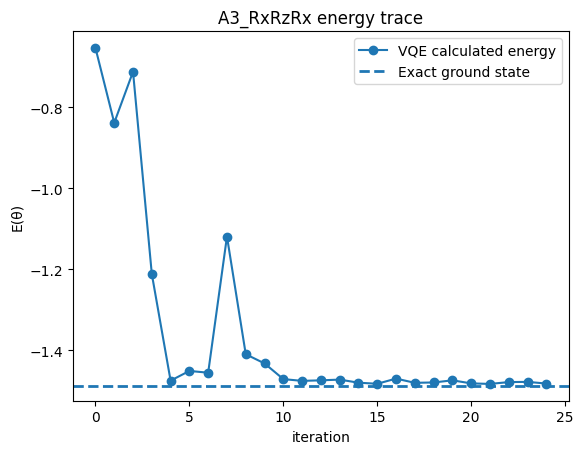

[saved] metrics JSON: figures/artifacts/ex_1/A3_RxRzRx_H_metrics.json
[saved] snapshots: figures/artifacts/ex_1/snapshots/A3_RxRzRx_H
[saved] GIF: figures/artifacts/ex_1/A3_RxRzRx_H_evolution.gif


In [7]:
# --- Run VQE for each ansatz and inspect with QSDs ---

results_ex1 = {}

for ansatz in ansatz_list:
    x0 = np.zeros(ansatz.num_parameters)
    res, hist = run_vqe_with_history(
        ansatz=ansatz,
        hamiltonian=h_hamiltonian,
        x0=x0,
        maxiter=25,
        tol=1e-3,
        shots=20_000,
        method="cobyla",
    )
    results_ex1[ansatz.name] = (res, hist)

    print(f"\n{ansatz.name}:")
    print("  final energy =", hist['cost_history'][-1])
    nit = getattr(res, "nit", None)
    if nit is None:
        nit = res.get("nit", hist.get("iters", len(hist.get("cost_history", []))))
    print("  nit =", nit)

    nfev = getattr(res, "nfev", None)

    print("  nit  =", nit if nit is not None else "(not provided; using history)")
    print("  iters recorded =", hist["iters"])
    print("  nfev =", nfev if nfev is not None else "(not provided)")


    # quick convergence plot
    plt.figure()
    plt.plot(hist["cost_history"], marker="o", label="VQE calculated energy")
    plt.axhline(E_ref, linestyle="--", linewidth=2, label="Exact ground state")
    plt.xlabel("iteration")
    plt.ylabel("E(θ)")
    plt.title(f"{ansatz.name} energy trace")
    plt.legend()
    plt.show()

    # QSD widget: scrub through *every* iteration
    qsd_iteration_widget(
        hist,
        title_prefix=f"{ansatz.name} (H)",
        run_tag=f"{ansatz.name}_H",
        out_dir="figures/artifacts/ex_1",
        gif_fps=1,
        gif_every=1,
        annotate_threshold=0.0001,
    )
    


### 1.3 What to look for in the QSD (Example 1)

With 1 qubit, excitation grouping yields two rows:

- row $(r=0)$: $(|0\rangle)$
- row $(r=1)$: $(|1\rangle)$

The QSD widget helps you see:

- **population transfer** between $(|0\rangle)$ and $(|1\rangle)$ as the optimizer updates $(\theta)$,
- whether the optimizer is actually changing the **phase structure** (hue) or only magnitudes,
- how the paper metrics behave iteration-by-iteration (not just at start/end).

Even in this tiny case, comparing ansatz is useful: an under-expressive ansatz can *appear* to “converge” while being structurally unable to reach the true ground state.


# Example 2 — $H_2$ “simple” reduced model (1 qubit + nuclear repulsion)

This example follows chemistry convention more closely:

- the electronic Hamiltonian is mapped to a **qubit Hamiltonian** (already provided),
- and the **nuclear repulsion energy** $(E_\mathrm{nuc})$ is added as a constant shift to get the total molecular energy.

We keep the workflow identical:
1) define $(\hat H)$
2) choose an ansatz
3) run VQE
4) use QSDs to diagnose the optimization trajectory.

> Why keep a 1-qubit reduced $H_2$ model?  
> It lets readers understand the chemistry-style bookkeeping (including the $(E_\mathrm{nuc})$ shift) before we jump to the “proper” multi-qubit Hamiltonian in Example 3.


H2 electronic Hamiltonian: SparsePauliOp(['I', 'Z', 'X'],
              coeffs=[-1.85727503+0.j, -0.23533786+0.j,  0.1809312 +0.j])
E_nuc = 0.7199689944489797
Exact ground state energy = -1.4341561735448312 Ha


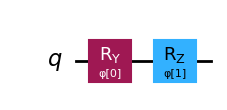

Final electronic energy  = -2.1524852824829055
Final total energy (add E_nuc) = -1.4325162880339257


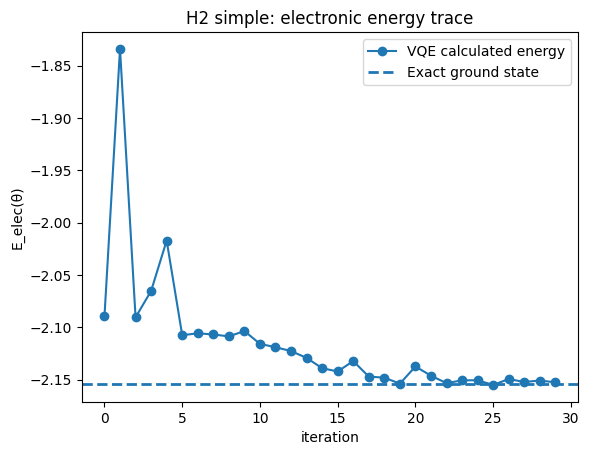

[saved] metrics JSON: figures/artifacts/ex_2/Example_2_H2_simple_metrics.json
[saved] snapshots: figures/artifacts/ex_2/snapshots/Example_2_H2_simple
[saved] GIF: figures/artifacts/ex_2/Example_2_H2_simple_evolution.gif


In [8]:
# --- Hamiltonian for H2 simple (1 qubit) ---
h2_hamiltonian = SparsePauliOp.from_list(
    [
        ("I", -1.857275027031588),
        ("Z", -0.23533785741764996),
        ("X",  0.18093119978423156),
    ]
)
h2_nuclear_repulsion = 0.7199689944489797

print("H2 electronic Hamiltonian:", h2_hamiltonian)
print("E_nuc =", h2_nuclear_repulsion)
E_h2_ref = exact_ground_state_energy(h2_hamiltonian)
print("Exact ground state energy =", E_h2_ref + h2_nuclear_repulsion, "Ha")

# A compact 1-qubit ansatz for H2
phi = ParameterVector("φ", 2)
ansatz_h2 = QuantumCircuit(1, name="H2_RyRz")
ansatz_h2.ry(phi[0], 0)
ansatz_h2.rz(phi[1], 0)
display(ansatz_h2.draw("mpl"))

# Run VQE
x0 = np.zeros(ansatz_h2.num_parameters)
res2, hist2 = run_vqe_with_history(
    ansatz=ansatz_h2,
    hamiltonian=h2_hamiltonian,
    x0=x0,
    maxiter=30,
    tol=1e-3,
    shots=20_000,
    method="cobyla",
)

E_elec = hist2["cost_history"][-1]
E_total = E_elec + h2_nuclear_repulsion

print("Final electronic energy  =", E_elec)
print("Final total energy (add E_nuc) =", E_total)

plt.figure()
plt.plot(hist2["cost_history"], marker="o", label="VQE calculated energy")
plt.axhline(E_h2_ref, linestyle="--", linewidth=2, label="Exact ground state")
plt.xlabel("iteration")
plt.ylabel("E_elec(θ)")
plt.title("H2 simple: electronic energy trace")
plt.legend()
plt.show()

qsd_iteration_widget(
    hist2,
    title_prefix="Example 2 (H2 simple)",
    run_tag="Example_2_H2_simple",
    out_dir="figures/artifacts/ex_2",
    gif_fps=1,
    gif_every=1,
    annotate_threshold=0.0001,
)


### 2.1 What this teaches

Even though this model is still only 1 qubit, it teaches two important “chemistry workflow” habits:

- **Separate** electronic energy from the constant nuclear repulsion shift, and report the total $(E_\mathrm{tot}=E_\mathrm{elec}+E_\mathrm{nuc})$.
- Keep diagnostics (QSD + metrics) **in the loop**: you can see if the optimizer is actually exploring the relevant part of Hilbert space, or if it is stuck in a narrow pattern.

Next, we scale up to a multi-qubit Hamiltonian where the **sector structure** becomes truly diagnostic.


# Example 3 — $H_2$ “proper” qubit Hamiltonian (4 qubits): diagnose & fix sector leakage

This is the main QSD showcase.

Here we use a **4‑qubit** Hamiltonian for $H_2$ (STO‑3G + Jordan–Wigner mapping, without 2‑qubit reduction).  
In this representation, **electron number / excitation structure** becomes meaningful: the physically relevant ground state is expected to live largely in a **fixed excitation sector**.

With excitation/Hamming-weight grouping $G=\mathrm{wt}(\cdot)$, the QSD lets us directly observe:

- whether the optimizer **leaks population** into the wrong sectors,
- which ansatz choices cause leakage,
- and how a structure-respecting ansatz can reduce leakage and stabilize optimization.

## 3.1 Hamiltonian

We hard-code the 4-qubit qubit Hamiltonian as a `SparsePauliOp` (Pauli string + coefficient list).

## 3.2 Two ansatz: generic n-local vs excitation-preserving

- **(A) Generic n-local ansatz**:
  flexible, but it does *not* preserve excitation number → can leak across rows.

- **(B) Excitation-preserving ansatz**:
  designed to preserve total excitation → should strongly suppress leakage.

To compare fairly, both ansatz start from the same **Hartree–Fock (HF)** computational basis state (a fixed excitation sector).


In [9]:
# --- H2 proper (4 qubits) Hamiltonian ---
# Coefficients taken from IBM Quantum Learning material (4-qubit H2 qubit Hamiltonian example).
h2_4q_hamiltonian = SparsePauliOp(
    [
        "IIII", "IIIZ", "IIZI", "IIZZ",
        "IZII", "IZIZ", "ZZII",
        "IIXX", "IIYY",
        "IXXI", "IYYI",
        "IZZI", "ZIZI",
        "XIIX", "YIIY",
    ],
    coeffs=[
        -0.09820182,
        -0.1740751,
        -0.1740751,
         0.2242933,
         0.2242933,
         0.16891402,
         0.1210099,
         0.16631441,
         0.16631441,
         0.1210099,
         0.17504456,
         0.04530451,
         0.04530451,
         0.04530451,
         0.04530451,
    ],
)

# Optional: if you want to report E_total, add a known E_nuc for the chosen bond length.
# (Keep this explicit rather than hiding it in the Hamiltonian.)
h2_4q_E_nuc = 0.7199689944489797  # same as Example 2's bond length convention

print("H2 4-qubit Hamiltonian has", len(h2_4q_hamiltonian), "Pauli terms")
E_ref_elec = exact_ground_state_energy(h2_4q_hamiltonian)
E_ref_total = E_ref_elec + h2_4q_E_nuc
print("Exact electronic ground energy =", E_ref_elec, "Ha")
print("Exact total (elec+nuc) =", E_ref_total, "Ha")

H2 4-qubit Hamiltonian has 15 Pauli terms
Exact electronic ground energy = -1.0655493387737276 Ha
Exact total (elec+nuc) = -0.34558034432474793 Ha


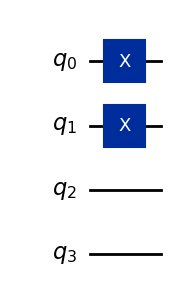

A_n_local num_params = 24 depth = 17


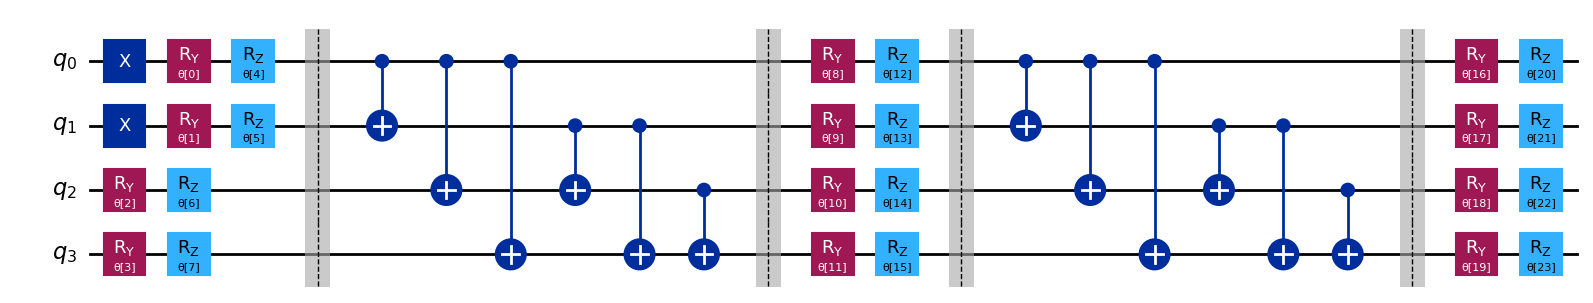

B_excitation_preserving num_params = 24 depth = 14


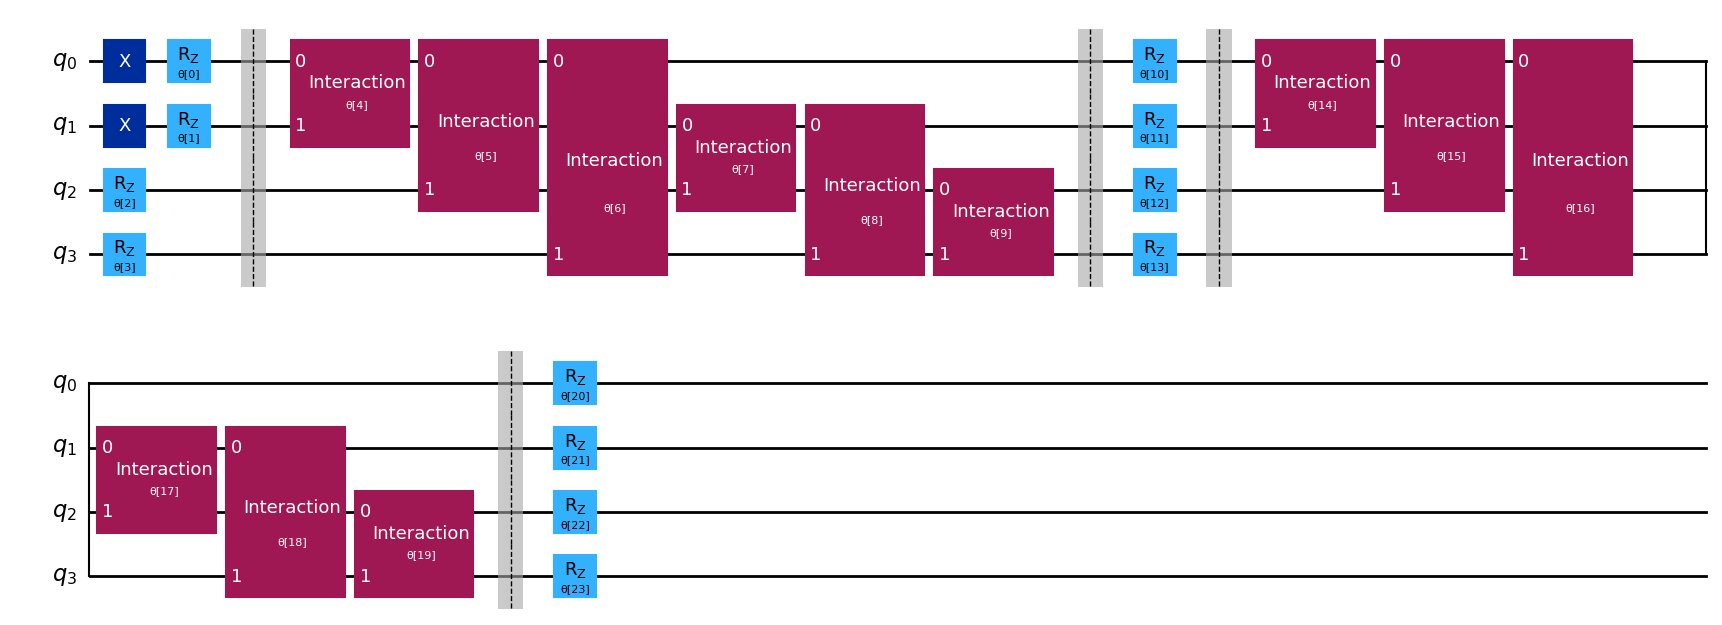

In [10]:
# --- Hartree–Fock initial state (2 excitations on 4 qubits) ---
hf = QuantumCircuit(4, name="HF")
hf.x(0)
hf.x(1)
display(hf.draw("mpl"))

# Target excitation sector for H2 with 2 electrons in 4 spin-orbitals (in this qubit encoding)
r_star = 2

# (A) Generic n-local ansatz (TwoLocal replacement)
nl_layer = n_local(
    num_qubits=4,
    rotation_blocks=["ry", "rz"],
    entanglement_blocks="cx",
    entanglement="full",
    reps=2,
    insert_barriers=True,
    parameter_prefix="θ",
)
ansatz_nlocal = hf.compose(nl_layer)
ansatz_nlocal.name = "A_n_local"

# (B) Excitation-preserving ansatz (ExcitationPreserving replacement)
ep_layer = excitation_preserving(
    num_qubits=4,
    entanglement="full",
    reps=2,
    insert_barriers=True,
    parameter_prefix="θ",
)
ansatz_ep = hf.compose(ep_layer)
ansatz_ep.name = "B_excitation_preserving"

for a in [ansatz_nlocal, ansatz_ep]:
    print(a.name, "num_params =", a.num_parameters, "depth =", a.depth())
    display(a.draw("mpl"))



A_n_local:
  final energy (as defined by H) = -0.39714658438733347
  if adding E_nuc (optional): 0.3228224100616462


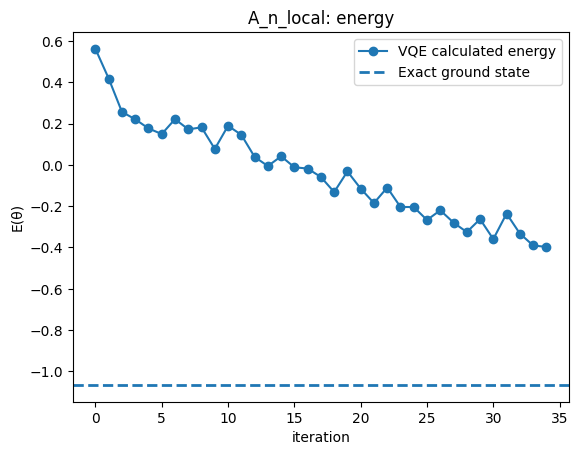

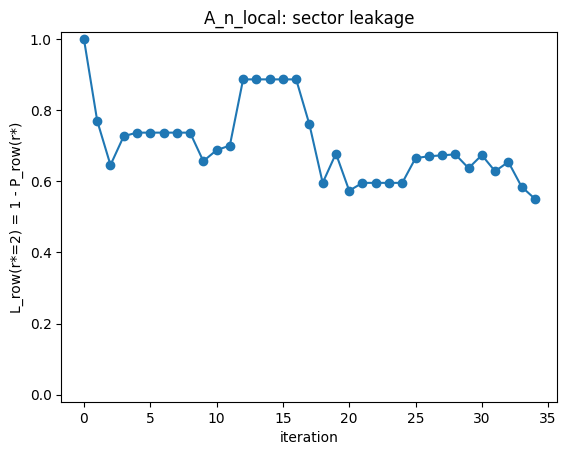

[saved] metrics JSON: figures/artifacts/ex_3/A_n_local_H2_4q_metrics.json
[saved] snapshots: figures/artifacts/ex_3/snapshots/A_n_local_H2_4q
[saved] GIF: figures/artifacts/ex_3/A_n_local_H2_4q_evolution.gif



B_excitation_preserving:
  final energy (as defined by H) = -0.7456913026713335
  if adding E_nuc (optional): -0.025722308222353885


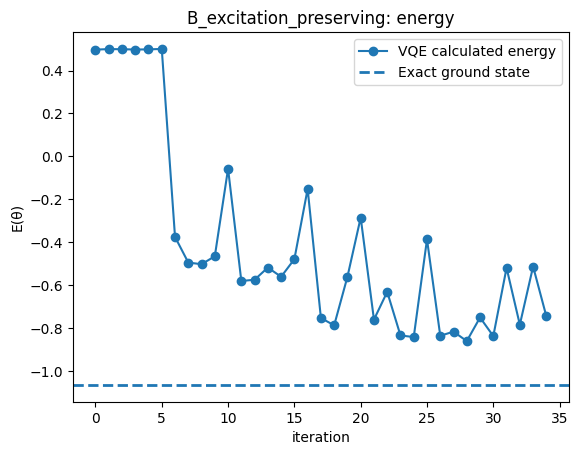

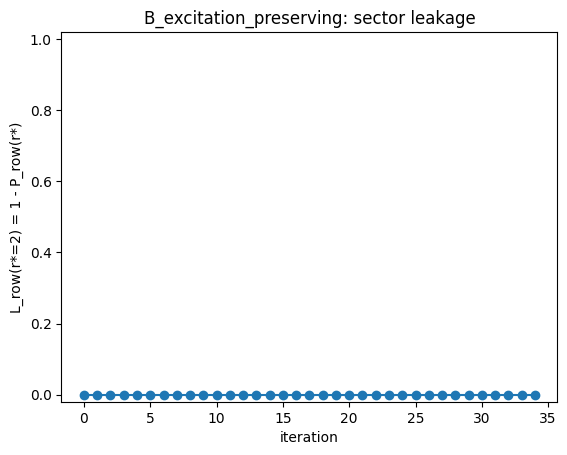

[saved] metrics JSON: figures/artifacts/ex_3/B_excitation_preserving_H2_4q_metrics.json
[saved] snapshots: figures/artifacts/ex_3/snapshots/B_excitation_preserving_H2_4q
[saved] GIF: figures/artifacts/ex_3/B_excitation_preserving_H2_4q_evolution.gif


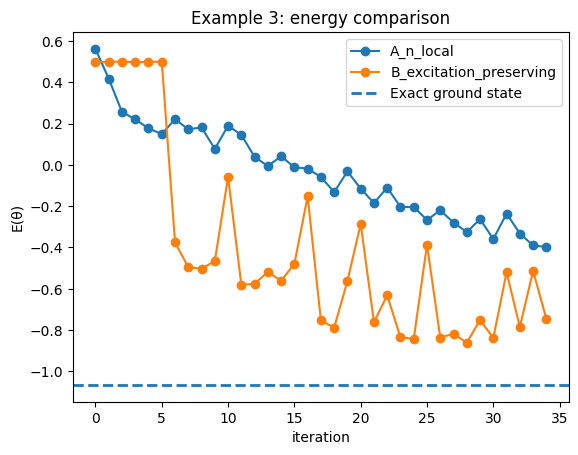

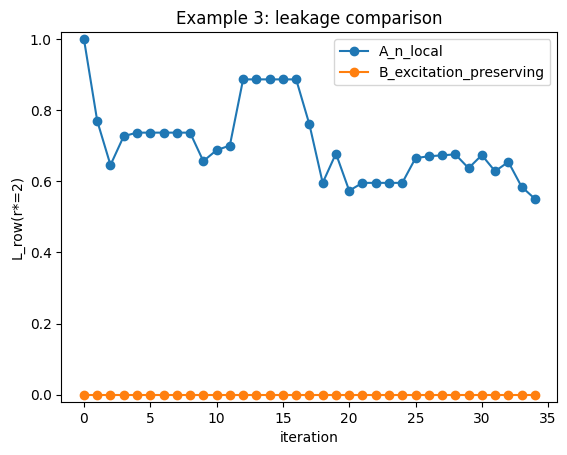

In [14]:
def leakage_trace(history, r_star: int, *, grouping="hamming", ordering="lex"):
    """
    Leakage trace over iterations:
      L(i) = 1 - P_row(r_star) for the i-th stored statevector.
    Uses compute_qsd_metrics() so it matches paper definitions.
    """
    L = []
    for sv in history["statevector_history"]:
        psi = sv.data if hasattr(sv, "data") else np.asarray(sv, dtype=complex)
        m = compute_qsd_metrics(psi, grouping=grouping, ordering=ordering)

        # row keys are strings in the metrics dict
        P_target = m["row_probabilities"].get(str(r_star), 0.0)
        L.append(1.0 - P_target)
    return L

    

results_ex3 = {}

for ansatz in [ansatz_nlocal, ansatz_ep]:
    x0 = np.zeros(ansatz.num_parameters)
    res, hist = run_vqe_with_history(
        ansatz=ansatz,
        hamiltonian=h2_4q_hamiltonian,
        x0=x0,
        maxiter=35,
        tol=1e-3,
        shots=30_000,
        method="cobyla",
    )
    results_ex3[ansatz.name] = (res, hist)

    E_elec = hist["cost_history"][-1]
    print(f"\n{ansatz.name}:")
    print("  final energy (as defined by H) =", E_elec)
    print("  if adding E_nuc (optional):", E_elec + h2_4q_E_nuc)

    L = leakage_trace(hist, r_star=r_star)

    # Energy and leakage traces
    plt.figure()
    plt.plot(hist["cost_history"], marker="o", label="VQE calculated energy")
    plt.axhline(E_ref_elec, linestyle="--", linewidth=2, label="Exact ground state")
    plt.xlabel("iteration")
    plt.ylabel("E(θ)")
    plt.title(f"{ansatz.name}: energy")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(L, marker="o")
    plt.xlabel("iteration")
    plt.ylabel(f"L_row(r*={r_star}) = 1 - P_row(r*)")
    plt.title(f"{ansatz.name}: sector leakage")
    plt.ylim(-0.02, 1.02)
    plt.show()

    # QSD iteration widget
    qsd_iteration_widget(
        hist,
        title_prefix=f"{ansatz.name} (H2 4q)",
        run_tag=f"{ansatz.name}_H2_4q",
        out_dir="figures/artifacts/ex_3",
        gif_fps=1,
        gif_every=1,
        annotate_threshold=0.0001,
    )

# Side-by-side comparison plot
plt.figure()
for name, (_, hist) in results_ex3.items():
    plt.plot(hist["cost_history"], marker="o", label=name)
plt.axhline(E_ref_elec, linestyle="--", linewidth=2, label="Exact ground state")
plt.xlabel("iteration")
plt.ylabel("E(θ)")
plt.title("Example 3: energy comparison")
plt.legend()
plt.show()

plt.figure()
for name, (_, hist) in results_ex3.items():
    plt.plot(leakage_trace(hist, r_star=r_star), marker="o", label=name)
plt.xlabel("iteration")
plt.ylabel(f"L_row(r*={r_star})")
plt.title("Example 3: leakage comparison")
plt.ylim(-0.02, 1.02)
plt.legend()
plt.show()


# Summary and next steps

What each example contributed:

- **Example 1 (H, 1q):** establishes the VQE loop, highlights ansatz expressivity, and shows how QSDs + paper metrics evolve **per iteration**.
- **Example 2 ($H_2$ simple, 1q):** adds the chemistry-style bookkeeping of $(E_\mathrm{nuc})$ and reinforces “keep diagnostics in the loop”.
- **Example 3 ($H_2$ proper, 4q):** demonstrates the core QSD value: with excitation grouping, you can *see* sector leakage and then *fix* it by choosing an ansatz that respects the structure.

Practical recommendations:

1. Pick a physically motivated grouping $(G)$ (excitation number, symmetry sector, etc.).
2. Track $P_{\mathrm{row}}(r)$ and $L_{\mathrm{row}}(r_\star)$ during optimization — don’t wait until the final state.
3. If leakage is large, switch to (or augment with) a structure-respecting ansatz (e.g., excitation-preserving layers, symmetry-preserving constructions).
4. Use $C_{\mathrm{row}}(r)$ as a quick “phase alignment” indicator inside populated sectors; use $S_{\mathrm{amp}}(r)$ / $N_{\mathrm{eff}}(r)$ to quantify within-row spread.
